In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.signal import find_peaks


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

3573.582275390625 electron / s


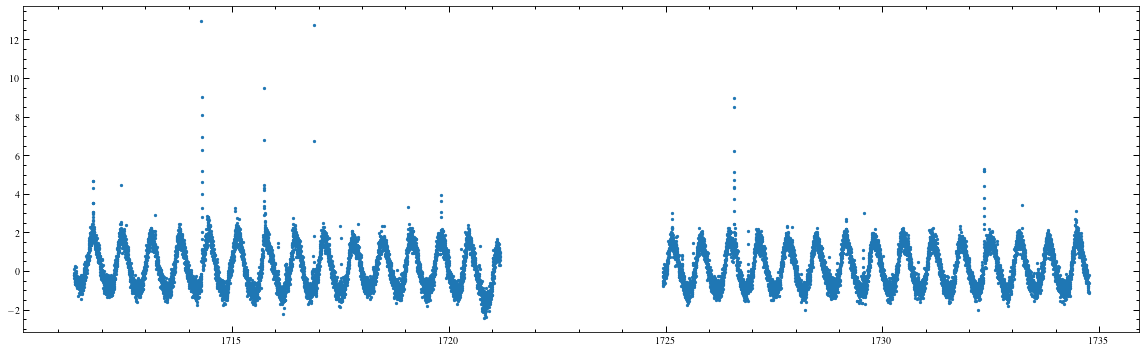

3495.080810546875 electron / s


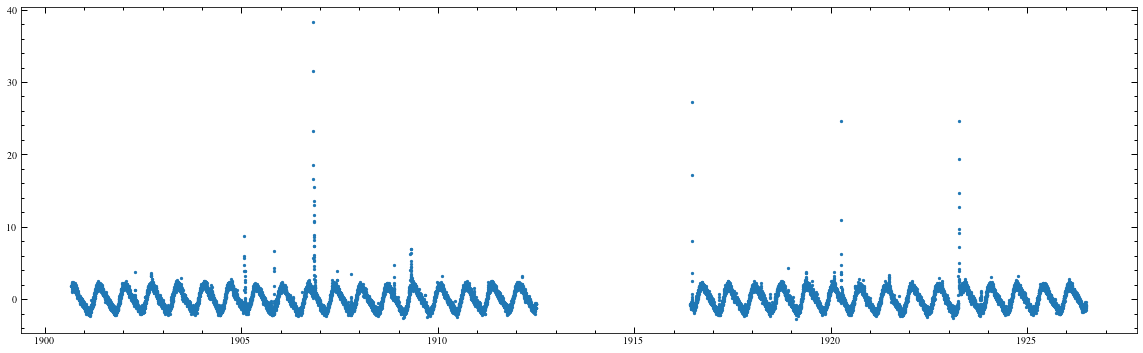

In [2]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
 #   print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
  #  t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
   # t, f, e = t[q==0], f[q==0], e[q==0]
    lc = lk.read(tessfits)
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
    #med = np.median(f)
    #print(med)
   # f = (f/med)-1
   # print(f)
   # e = (e/med)
    plt.figure(figsize=(20, 6))
#     lc = lk.LightCurve(time=t*u.d, flux=f, flux_err=e)#.remove_outliers(sigma=5)#.flatten(window_length=1001).remove_nans()
    lc = lc.remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
    plt.scatter(lc.time.value,lc.flux, s=5)
    #plt.axhline(med*100, c='C1')
    plt.show()
    
    #plt.subplot(131)

183.933741620044 52.5170250022383
3573.211669921875 electron / s
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          frequency            phase       
    ------------------ ------------------ ------------------
    1.3227048958821084 1.4976570296777938 -0.448790865679026
<class 'numpy.ndarray'>
183.933741620044 52.5170250022383
3494.290283203125 electron / s
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude          frequency           phase       
    ------------------- ----------------- ------------------
    -1.6484615694987355 1.497864930618863 -3.300093763579851
<class 'numpy.ndarray'>


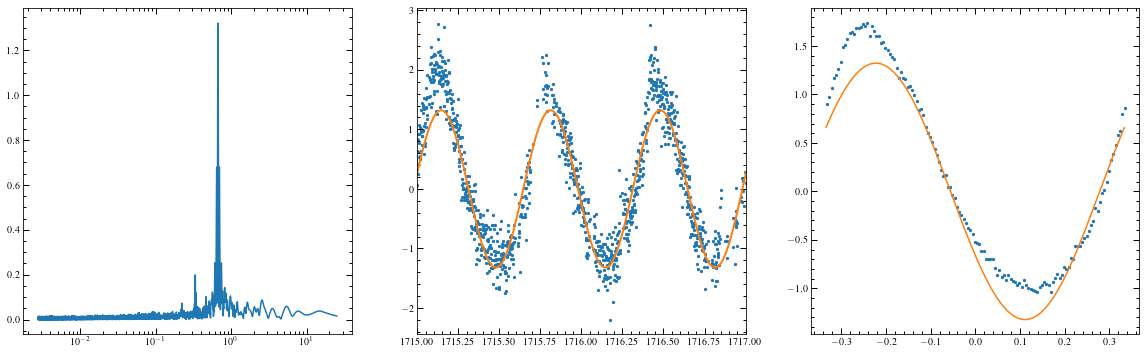

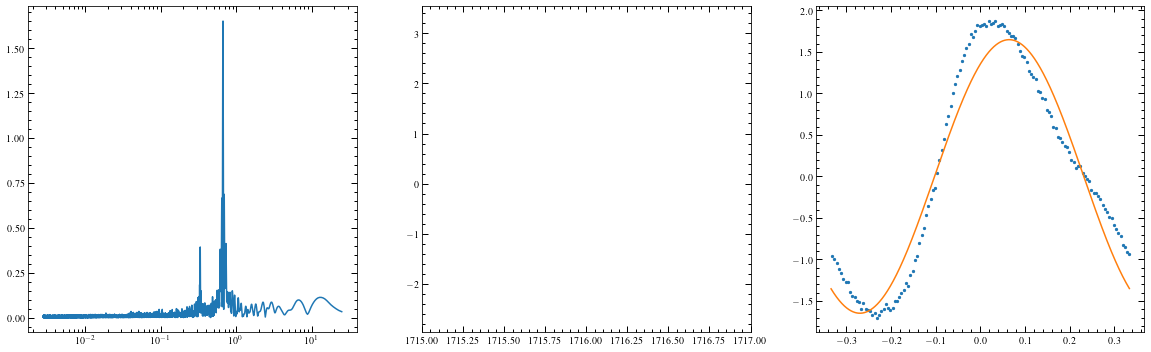

In [3]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']

preds = ['lc1_preds.npy', 'lc2_preds.npy']
fitter = fitting.LevMarLSQFitter()




for i, tessfits in enumerate(eg_uma_fits):
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
    print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
#     t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
#     t, f, e = t[q==0], f[q==0], e[q==0]  
    lc = lk.read(tessfits).remove_nans()
    flares = np.load(preds[i])
    mask = (flares <0.5)
    lc = lc[mask]
    
    if i == 0: #removing weird bit on end
        mask = (lc.time.value < 1720) | (lc.time.value > 1722)
        lc = lc[mask]
    
    if i == 1: #removing the flare stella missed
        mask = (lc.time.value < 1916.4) | (lc.time.value > 1916.6)
        lc = lc[mask]
    
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
 #   med = np.median(f)
   # print(med)
  #  f = (f/med)-1
  #  print(f)
  #  e = (e/med)
    plt.figure(figsize=(20, 6))
#     lc = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).remove_nans()#.flatten(window_length=1001).remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
#     lc = lc.flatten(3001)
    lc.flux = lc.flux.value
    lc.flux_err = lc.flux_err.value
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
  
    
    plt.subplot(131)

    
#     mask = (lc.flux <3) #flares 
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
    plt.plot(pg.period, pg.power)
    plt.xscale('log')
    
    plt.subplot(132)
    plt.scatter(lc.time.value,lc.flux, s=5)
    

    
    sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value) #+ models.Sine1D(amplitude=pg.max_power, frequency= (pg.frequency_at_max_power.value)*2)
    sin_fit = fitter(sin_mod, lc.time.value, lc.flux.value, weights = 1/lc.flux_err.value, maxiter=10000)
    print(sin_fit)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    timefit = np.linspace(lc.time[0].value, lc.time[-1].value, 2000)
#     timefit = np.linspace(1710, 1740, 2000)
    print(type(timefit))
    plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
    plt.xlim(1715, 1717)
#     print('Period =', (1/sin_fit[0].frequency.value)*24, (sin_fit_e[1]/(sin_fit[0].frequency.value**2))*24, 'h')
#     print('Period2 =', (1/sin_fit[1].frequency.value)*24, (sin_fit_e[4]/(sin_fit[1].frequency.value**2))*24, 'h')
#     print('Amplitude =', sin_fit[0].amplitude.value, sin_fit_e[0])
#     print('Amplitude2 =', sin_fit[1].amplitude.value, sin_fit_e[3])

    

#     print(pg.period_at_max_power.to(u.hour))
    plt.subplot(133)
    lcf = lc.fold(1/sin_fit.frequency).bin(0.005)
    mf = lk.LightCurve(time=timefit, flux=sin_fit(timefit)).fold(1/sin_fit.frequency)
    plt.scatter(lcf.time.value, lcf.flux, s=5)
    plt.plot(mf.time.value, mf.flux, c='C1')
    

13924 13924
12684


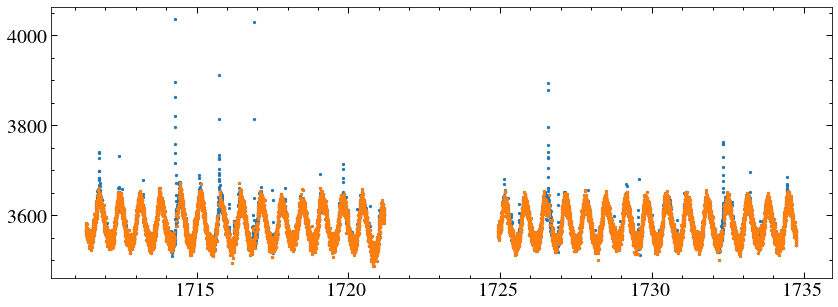

In [163]:
preds2 = np.load('lc1_preds.npy')
lc = lk.read(eg_uma_fits[0]).remove_nans()
print(len(preds2), len(lc))
# plt.scatter(lc.time.value, preds1)
plt.scatter(lc.time.value,lc.flux, s=5)
mask = (preds2 < 0.1)
plt.scatter(lc.time.value[mask],lc.flux[mask], s=5)
# plt.xlim(1916, 1917)
print(len(lc.time[mask]))

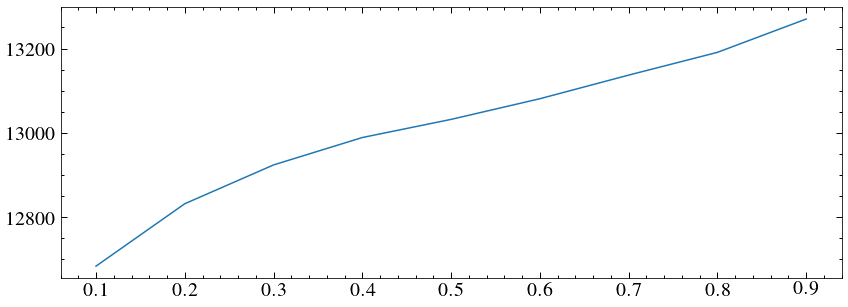

In [162]:
probs = np.arange(0.1, 1, 0.1)
lens = []
for prob in probs:
    pmask = preds2< prob
    lens.append(len(lc[pmask]))
plt.plot(probs, lens)

JJ thinks it's ok just to fit a sin wave to measrue the ephemeris

0.667133526198175 d
16.0112046287562 h


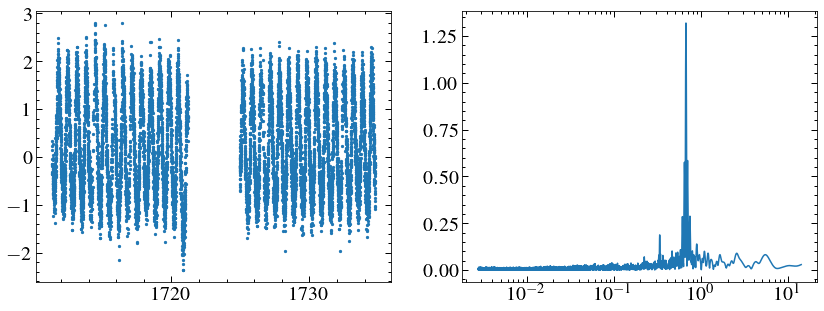

In [164]:
lcnf = lc[mask]#flatten(601)
lcnf=lcnf.remove_nans()
lcnf = lcnf.normalize()
lcnf.flux =lcnf.flux.value-1 
lcnf.flux *=100
lcnf.flux_err = lcnf.flux_err.value -  100
plt.subplot(121)
plt.scatter(lcnf.time.value, lcnf.flux, s=5)
plt.subplot(122)
pg = lcnf.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=14*u.day)
plt.plot(pg.period, pg.power)
plt.xscale('log')
print(pg.period_at_max_power)
print(pg.period_at_max_power.to(u.hr))

0.6684953256775916 d
[1.08825242 0.88626452 0.79045144 0.74042253 0.69634948 0.66849533
 0.64102275 0.60772268 0.57771153 0.46239707 0.33376982] d


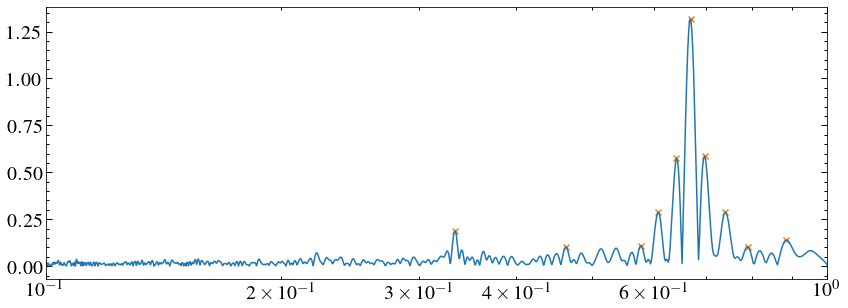

In [165]:
pg = lcnf.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=13*u.day)
plt.plot(pg.period, pg.power)
# plt.xscale('log')
plt.xlim(0.1, 1)
print(pg.period_at_max_power)
peaks =find_peaks(pg.power, height=0.1)
# plt.plot(pg.period, pg.power)
plt.xscale('log')
plt.scatter(pg.period[peaks[0]], pg.power[peaks[0]], marker='x', c='C1')
print(pg.period[peaks[0]])

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude         frequency             phase       
    ----------------- ------------------ -------------------
    1.320612193924739 1.4977217732872394 -0.5616966181337804
<class 'numpy.ndarray'>


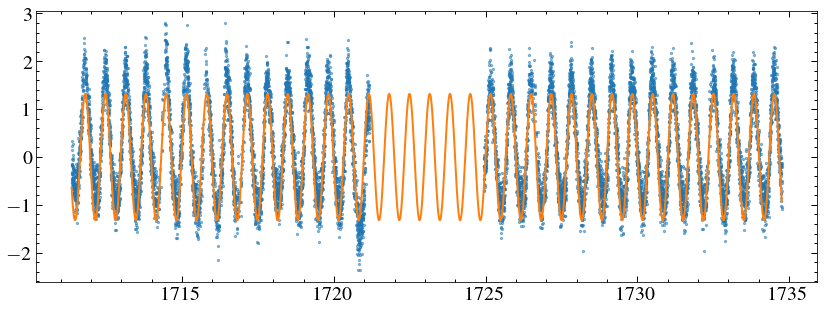

In [166]:
sin_mod =  models.Sine1D(amplitude=pg.max_power.value, frequency= 1/0.6678064565545051)#+ models.Sine1D(amplitude=1, frequency= 1/0.69767624)+ models.Sine1D(amplitude=1, frequency=1/0.64214689)
sin_fit = fitter(sin_mod, lcnf.time.value, lcnf.flux, weights = 1/lcnf.flux_err, maxiter=10000)
print(sin_fit)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit = np.linspace(lcnf.time[0].value, lcnf.time[-1].value, 2000)
#     timefit = np.linspace(1710, 1740, 2000)
print(type(timefit))
plt.scatter(lcnf.time.value,lcnf.flux, s=5, alpha=0.5)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
# plt.xlim(1730, 1731)

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude      frequency        phase       
    ------------------- --------- -------------------
    -1.3206121933653772       1.0 0.08127749847940781


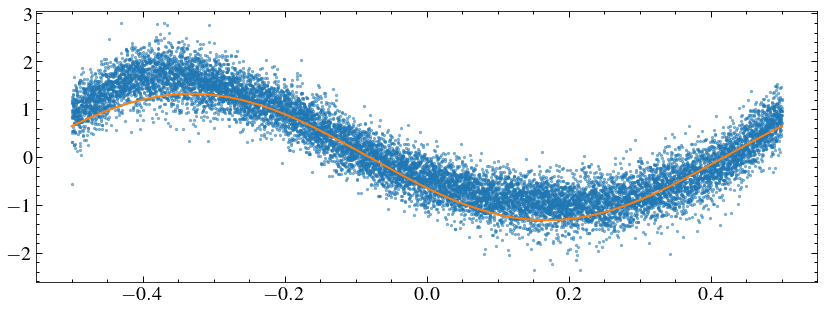

In [167]:
lcfold = lcnf.fold(period = 1/sin_fit.frequency, normalize_phase=True)
plt.scatter(lcfold.time.value,lcfold.flux, s=5, alpha=0.5)

sin_mod2 =  models.Sine1D(amplitude=1.5, frequency= 1,fixed = dict(frequency=True))
sin_fit2 = fitter(sin_mod2, lcfold.time.value, lcfold.flux.value, weights = 1/lcfold.flux_err.value, maxiter=10000)
print(sin_fit2)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefold = np.linspace(-0.5, 0.5, 1000)
plt.plot(timefold, sin_fit2(timefold), lw=2, c='C1')


Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude         frequency             phase        
    ----------------- ------------------ --------------------
    1.320612193365257 1.4977217732872394 -0.41872250152828244


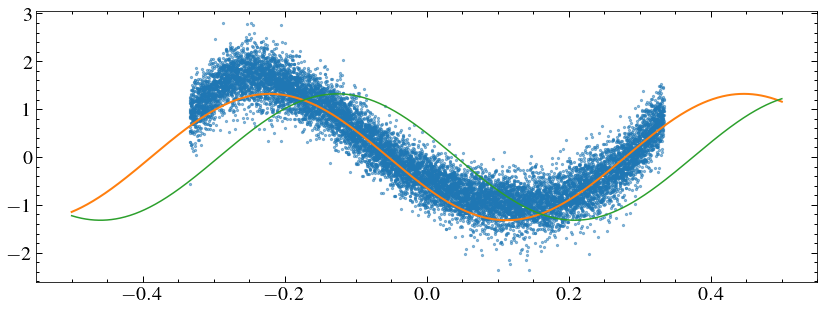

In [168]:
lcfold = lcnf.fold(period = 1/sin_fit.frequency)
plt.scatter(lcfold.time.value,lcfold.flux, s=5, alpha=0.5)

sin_mod2 =  models.Sine1D(amplitude=sin_fit.amplitude, frequency= sin_fit.frequency, phase=sin_fit.phase, fixed = dict(frequency=True))
sin_fit2 = fitter(sin_mod2, lcfold.time.value, lcfold.flux.value, weights = 1/lcfold.flux_err.value, maxiter=10000)
print(sin_fit2)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefold = np.linspace(-0.5, 0.5, 1000)
plt.plot(timefold, sin_fit2(timefold), lw=2, c='C1')
plt.plot(timefold, sin_fit(timefold), c='C2')

1711.0816556962143
1723.2424079827806
1722.9628350280461
Parameter('phase', value=-0.5616966181337804) 0.13921437635026096
2458722.962835028


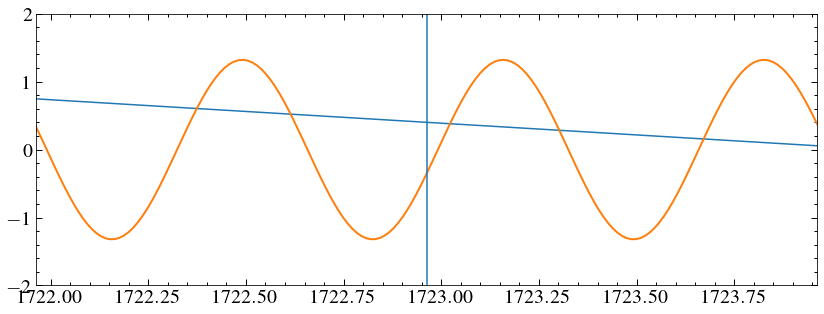

In [169]:
# t0 = (lcnf.time[0] + (1/sin_fit.frequency)*(sin_fit2.phase)).value #0.5 = inferior conjunction
# print(t0)

# tmid = (lcnf.time[0].value+lcnf.time[-1].value)/2
# print(tmid)
# eph = (t0 + tmid- lcnf.time[0].value)
# print(eph)
# sin_mod3 =  models.Sine1D(amplitude=sin_fit2.amplitude, frequency= sin_fit2.frequency, phase=sin_fit2.phase)
# plt.plot(lcnf.time.value, lcnf.flux)
# plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
# plt.xlim(eph-1, eph+1)
# plt.axvline(eph)
# plt.axvline(t0)
# # plt.axvline(tmid)
# plt.ylim(-2, 2)
# print(sin_fit2.phase, sin_fit_e2[1])


# print(eph+2457000)


t0 = lcnf.time[0].value + (1/sin_fit.frequency)*(sin_fit2.phase) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lcnf.time.value)
print(tmid)
eph = t0 + np.mean(lcnf.time.value)- lcnf.time[0].value
print(eph)
plt.plot(lcnf.time.value, lcnf.flux)

plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
# plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
print(sin_fit.phase, sin_fit_e[2])
# plt.plot(lc1.time, lc1.flux)
plt.xlim(eph-1, eph+1)
plt.ylim(-2, 2)
print(eph+2457000)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

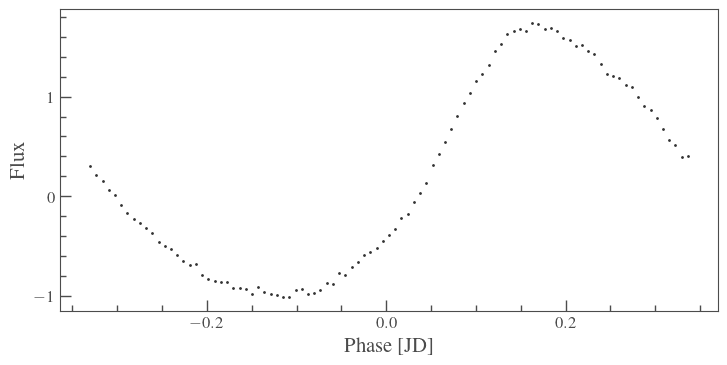

In [170]:
lcnf.fold(1/sin_fit.frequency, epoch_time=eph).bin(10*u.min).scatter()

[[Model]]
    Model(sin)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12684
    # variables        = 3
    chi-square         = 1983.32296
    reduced chi-square = 0.15640115
    Akaike info crit   = -23530.0201
    Bayesian info crit = -23507.6759
[[Variables]]
    freq:   1.49772181 +/- 8.0785e-05 (0.01%) (init = 1.495897)
    amp:   -1.32061181 +/- 0.00497323 (0.38%) (init = 1.5)
    phase: -3.06175645 +/- 0.13921559 (4.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(freq, phase) = -1.000


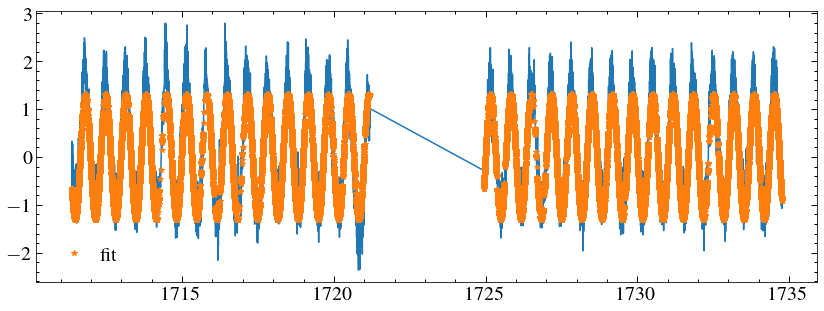

0.6676807366013595
[[Model]]
    Model(sin_fix)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 12684
    # variables        = 2
    chi-square         = 1983.32296
    reduced chi-square = 0.15638882
    Akaike info crit   = -23532.0201
    Bayesian info crit = -23517.1240
[[Variables]]
    amp:   -1.32061208 +/- 0.00497143 (0.38%) (init = -1.320612)
    phase:  0.08127709 +/- 5.9786e-04 (0.74%) (init = 0)


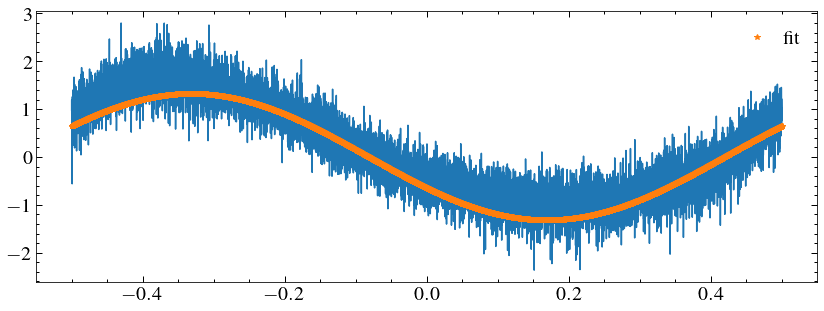

In [171]:
from lmfit import Model, Parameters

# def sinefunction(x, a, b, c):
#     return a + b * np.sin(x*np.pi/180.0 + c)


def sin(x, freq, amp, phase):
    """for fitting to time series"""
    return amp*np.sin(2.*np.pi*(freq*x+phase))

smodel = Model(sin)
result = smodel.fit(lcnf.flux, x=lcnf.time.value, freq=pg.frequency_at_max_power.value, amp=1.5, phase=0)

print(result.fit_report())

# plt.plot(xdeg, y, 'o', label='data')#
plt.plot(lcnf.time.value, lcnf.flux)

plt.plot(lcnf.time.value, result.best_fit, '*', label='fit')
plt.legend()
plt.show()

p1 = 1/(result.best_values['freq'])
print(p1)
lcfold = lcnf.fold(p1, normalize_phase=True)

def sin_fix(x, amp, phase):
    """for fitting to time series"""
    return amp*np.sin(2.*np.pi*(1*x+phase))

foldmodel = Model(sin_fix)

result2 = foldmodel.fit(lcfold.flux, x=lcfold.time.value, amp=result.best_values['amp'], phase=0)


print(result2.fit_report())

# plt.plot(xdeg, y, 'o', label='data')#
plt.plot(lcfold.time.value, lcfold.flux)

plt.plot(lcfold.time.value, result2.best_fit, '*', label='fit')
plt.legend()
plt.show()

1711.4154957988658
1723.2424079827806
1723.2966751306974
2458723.2966751307


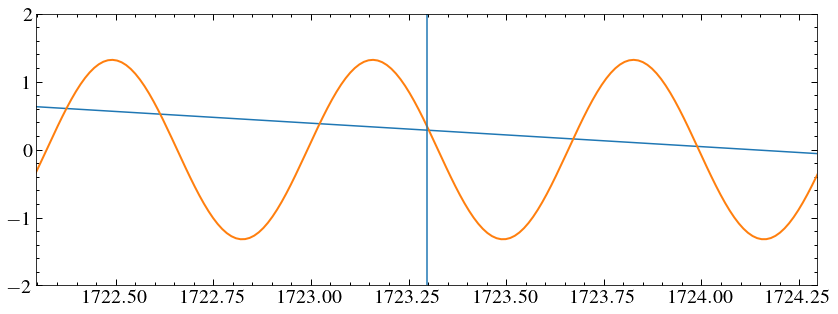

In [172]:
t0 = lcnf.time[0].value + (1/result.best_values['freq'])*(result2.best_values['phase'])#0.5 = inferior conjunction
print(t0)
tmid = np.mean(lcnf.time.value)
print(tmid)
eph = t0 + np.mean(lcnf.time.value)- lcnf.time[0].value
print(eph)
plt.plot(lcnf.time.value, lcnf.flux)

plt.plot(timefit, result.eval(x=timefit), c='C1', lw=2)
# plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
# print(sin_fit.phase, sin_fit_e[2])
# plt.plot(lc1.time, lc1.flux)
plt.xlim(eph-1, eph+1)
plt.ylim(-2, 2)
print(eph+2457000)

1723.4921229542779


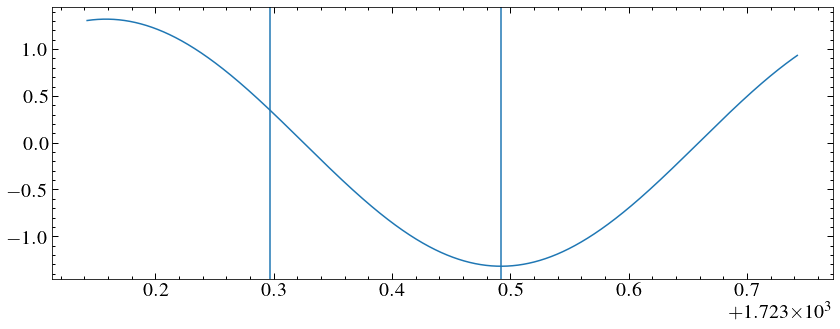

In [173]:
midrange= np.linspace(tmid-0.1, tmid+0.5, 10000)
midflux =  result.eval(x=midrange)
plt.plot(midrange, midflux)
plt.axvline(eph)
low = midrange[np.where((midflux == np.min(midflux)))[0][0]]
plt.axvline(low)
print(low)

rolling lombscargle?

In [174]:
# import math as mt
# days = np.unique([mt.floor(day) for day in lcnf.time.value])
# period_part = []
# power_part = []
# for day in days[1:-1]:
#     mask = (lcnf.time.value >=day-1) & (lcnf.time.value < day+2)
#     lc_part = lcnf[mask]
#     pg_part = lc_part.to_periodogram(oversample_factor=10, minimum_period=4*u.min, maximum_period=3*u.d)
#     plt.plot(pg_part.period, pg_part.power)
#     period_part.append(pg_part.period_at_max_power.value)
#     power_part.append(pg_part.max_power.value)
# plt.show()
# plt.plot(days[1:-1], period_part)
# plt.show()
# plt.plot(days[1:-1], power_part)
# plt.show()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

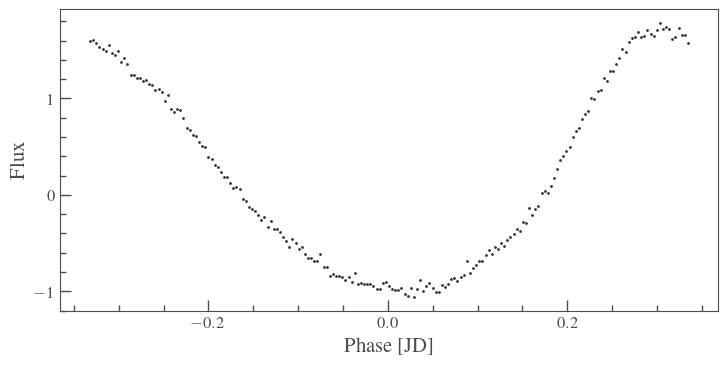

In [175]:
lcnf.fold(1/result.best_values['freq'], epoch_time = 1723.491750629676).bin(5*u.min).scatter()

In [176]:
1723.1238349352677 1723.1238341136316

SyntaxError: invalid syntax (<ipython-input-176-53ce19317712>, line 1)